First, we need to import the main libraries that we will definitely use later.

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.image import imread
import sys, os, shutil
import numpy as np

Train and test datasets must be seperated from each other, our is not right now. So let's seperate them. There is one issue that must be mentioned, there were not enough images in files of older ages etc 95,87 so I deleted the files that contain ages above 80. Also the model can be downloaded from kaggle, which is linked here:
https://www.kaggle.com/frabbisw/facial-age

In [7]:
data_dir = "face_age"
train_dir = "face_train_age"
test_size = 0.75
for i in range(1,10):
    name = "00" + str(i)
    os.makedirs(os.path.join(train_dir, name))
for i in range(10, 81):
    name = "0"+str(i)
    os.makedirs(os.path.join(train_dir, name))

for i in range(len(os.listdir(data_dir))):
    tfile = data_dir + "\\" + os.listdir(data_dir)[i]
    target_file = os.listdir(tfile)
    
    test_split = int(np.round(test_size * len(target_file)))
    for j in range(test_split):
        old_path = tfile + "\\" + target_file[-j]
        new_path = train_dir + "\\" +  os.listdir(data_dir)[i] + "\\" + target_file[-j]
        os.replace(old_path, new_path)




We need to create our augmented data which we can easily by the power of tensorflow

In [8]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255, horizontal_flip=True, rotation_range=0.2)
train_data = train_datagen.flow_from_directory(train_dir, batch_size=10, class_mode="categorical", target_size=(200,200))
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
testing_data = test_datagen.flow_from_directory(data_dir, batch_size=10, class_mode='categorical', target_size=(200,200), shuffle=False)

Found 7072 images belonging to 80 classes.
Found 2362 images belonging to 80 classes.


Create our callback class and model

In [9]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc') > 0.95):
            self.model.stop_training = True
            
callbacks = myCallback()

Epoch 1/35
708/708 [==============================] - 68s 95ms/step - loss: 3.8604 - acc: 0.1336 - val_loss: 3.5344 - val_acc: 0.1562
Epoch 2/35
708/708 [==============================] - 69s 97ms/step - loss: 3.3803 - acc: 0.1673 - val_loss: 3.3574 - val_acc: 0.1740
Epoch 3/35
708/708 [==============================] - 69s 98ms/step - loss: 3.1027 - acc: 0.2077 - val_loss: 3.2031 - val_acc: 0.1744
Epoch 4/35
708/708 [==============================] - 67s 95ms/step - loss: 2.8328 - acc: 0.2568 - val_loss: 3.2331 - val_acc: 0.1749
Epoch 5/35
708/708 [==============================] - 66s 93ms/step - loss: 2.5416 - acc: 0.3235 - val_loss: 3.2681 - val_acc: 0.1804
Epoch 6/35
708/708 [==============================] - 66s 94ms/step - loss: 2.2643 - acc: 0.3890 - val_loss: 3.5750 - val_acc: 0.1710
Epoch 7/35
708/708 [==============================] - 67s 94ms/step - loss: 1.9536 - acc: 0.4707 - val_loss: 3.6899 - val_acc: 0.1761
Epoch 8/35
708/708 [==============================] - 62s 88ms

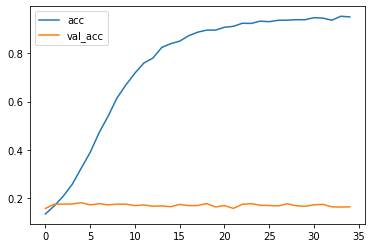

In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(200,200,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(80, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

r = model.fit_generator(train_data, validation_data=testing_data, epochs=35, callbacks=[callbacks])


plt.plot(r.history["acc"], label="acc")
plt.plot(r.history["val_acc"], label='val_acc')
plt.legend()



Let's save our model so we don't need to train it again and again

In [11]:
model.save_weights('my_weights')
model.save('my_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: my_model\assets


Our model just works fine, let's test it. I tested the model with a photo of a pretty girl, who is 19.

In [25]:
test_img = imread("alize.png", 0) / 255
print(type(test_img))
test_img = tf.expand_dims(test_img, 0)
print(test_img.shape)
class_names = train_data.class_indices
test_list = []
for x, y in class_names.items():
    test_list.append(y)


<class 'numpy.ndarray'>
(1, 200, 200, 3)


Model says she's only 16, seems she looks younger than she is lol

In [26]:
p = model.predict(test_img)
score = tf.nn.softmax(p[0])
print(test_list[np.argmax(score)]+1)


16
